In [3]:
%reload_ext autoreload
%autoreload 2

In [4]:
import torch
import numpy as np
from torch_geometric import utils
from torch_geometric.data import Data
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

In [5]:
x = torch.tensor([[2,1], [5,6], [3,7], [12,0]], dtype=torch.float)
y = torch.tensor([0, 1, 0, 1], dtype=torch.float)

In [6]:
edge_index = torch.tensor([[0, 1, 2, 0, 3],
                           [1, 0, 1, 3, 2]], dtype=torch.long)

In [7]:
# [num_edges, num_edge_features]
edge_attr = torch.tensor([4,10,3,1,5],dtype=torch.float)

In [8]:
g = Data(x=x,edge_index=edge_index,edge_attr=edge_attr,y=y)

In [9]:
def get_width(attr):
    return np.sqrt(np.sum(np.square(attr)))

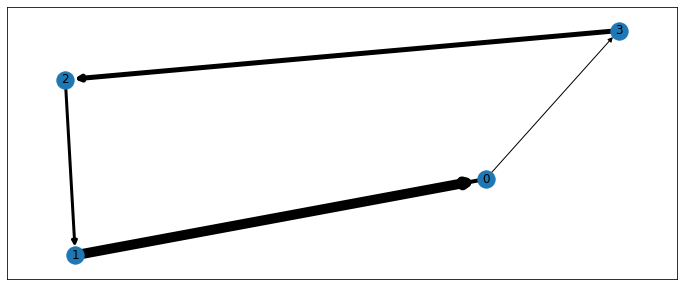

In [10]:
viz = utils.to_networkx(g,edge_attrs=["edge_attr"])
# labels = [i for i in dict(viz.nodes).keys()]
labels = {i:i for i in dict(viz.nodes).keys()}
width = [get_width(i['edge_attr']) for i in dict(viz.edges).values()]
fig, ax = plt.subplots(figsize=(12,5))
pos = nx.spring_layout(viz)
nx.draw_networkx_nodes(viz, pos, ax = ax, labels=True)
nx.draw_networkx_edges(viz, pos, ax=ax,width=width,style="solid")
_ = nx.draw_networkx_labels(viz, pos, labels, ax=ax)

In [11]:
viz.adj

AdjacencyView({0: {1: {'edge_attr': 4.0}, 3: {'edge_attr': 1.0}}, 1: {0: {'edge_attr': 10.0}}, 2: {1: {'edge_attr': 3.0}}, 3: {2: {'edge_attr': 5.0}}})

In [12]:
from torch_geometric.nn import GCNConv, SAGEConv
# from torch_geometric.utils.num_nodes import maybe_num_nodes
# from torch_geometric.utils import add_remaining_self_loops
# from torch_scatter import scatter_add

In [13]:
conv1 = SAGEConv(2, 2,normalize=True)

In [14]:
g.edge_index

tensor([[0, 1, 2, 0, 3],
        [1, 0, 1, 3, 2]])

In [15]:
op = conv1(g.x,g.edge_index)

{'x_j': tensor([[ 2.,  1.],
        [ 5.,  6.],
        [ 3.,  7.],
        [ 2.,  1.],
        [12.,  0.]]), 'adj_t': None, 'edge_index': tensor([[0, 1, 2, 0, 3],
        [1, 0, 1, 3, 2]]), 'edge_index_i': tensor([1, 0, 1, 3, 2]), 'edge_index_j': tensor([0, 1, 2, 0, 3]), 'ptr': None, 'index': tensor([1, 0, 1, 3, 2]), 'size_i': 4, 'size_j': 4, 'dim_size': 4}
{'x_j': tensor([[ 2.,  1.],
        [ 5.,  6.],
        [ 3.,  7.],
        [ 2.,  1.],
        [12.,  0.]])}
tensor([[ 2.,  1.],
        [ 5.,  6.],
        [ 3.,  7.],
        [ 2.,  1.],
        [12.,  0.]])
tensor([[ 5.0000,  6.0000],
        [ 2.5000,  4.0000],
        [12.0000,  0.0000],
        [ 2.0000,  1.0000]])
tensor([[-0.3426, -5.9185],
        [-0.4275, -3.2263],
        [ 4.5756, -7.9793],
        [ 0.6047, -1.4603]], grad_fn=<AddmmBackward>)
tensor([[-1.1472, -5.9019],
        [-0.4335, -4.3162],
        [ 6.5201, -9.7322],
        [-7.6608,  0.5786]], grad_fn=<AddBackward0>)
tensor([[-0.1908, -0.9816],
        [-0.

In [14]:
# https://pytorch.org/docs/master/nn.functional.html#torch.nn.functional.normalize

tensor([[-0.9837,  1.7200],
        [ 3.9761,  4.4613],
        [-0.3111,  7.7616],
        [ 4.1029,  7.8214]], grad_fn=<AddBackward0>)

In [50]:
def gcn_norm(edge_index,edge_weight=None,fill_value=1.,num_nodes=None, dtype=torch.float):
    num_nodes = maybe_num_nodes(edge_index, num_nodes)

    if edge_weight is None:
        edge_weight = torch.ones((edge_index.size(1), ), dtype=dtype,
                                 device=edge_index.device)

    if True:
        edge_index, tmp_edge_weight = add_remaining_self_loops(
            edge_index, edge_weight, fill_value, num_nodes)
        assert tmp_edge_weight is not None
        print(edge_index)
        print(tmp_edge_weight)
        edge_weight = tmp_edge_weight

    row, col = edge_index[0], edge_index[1]
    deg = scatter_add(edge_weight, col, dim=0, dim_size=num_nodes)
    print(deg)
    deg_inv_sqrt = deg.pow_(-0.5)
    deg_inv_sqrt.masked_fill_(deg_inv_sqrt == float('inf'), 0)
    print(deg_inv_sqrt)
    print(deg_inv_sqrt[row])
    print(deg_inv_sqrt[col])
    return edge_index, deg_inv_sqrt[row] * edge_weight * deg_inv_sqrt[col]

In [51]:
edge_index, edge_weight = gcn_norm(g.edge_index,g.edge_attr)

tensor([[0, 1, 2, 0, 3, 0, 1, 2, 3],
        [1, 0, 1, 3, 2, 0, 1, 2, 3]])
tensor([ 4., 10.,  3.,  1.,  5.,  1.,  1.,  1.,  1.])
tensor([11.,  8.,  6.,  2.])
tensor([0.3015, 0.3536, 0.4082, 0.7071])
tensor([0.3015, 0.3536, 0.4082, 0.3015, 0.7071, 0.3015, 0.3536, 0.4082, 0.7071])
tensor([0.3536, 0.3015, 0.3536, 0.7071, 0.4082, 0.3015, 0.3536, 0.4082, 0.7071])


In [47]:
edge_weight

tensor([0.4264, 1.0660, 0.4330, 0.2132, 1.4434, 0.0909, 0.1250, 0.1667, 0.5000])

In [64]:
import torch
from torch_scatter.utils import broadcast
from typing import Optional, Tuple

In [98]:
@torch.jit.script
def scatter_sum(src: torch.Tensor, index: torch.Tensor, dim: int = -1,
                out: Optional[torch.Tensor] = None,
                dim_size: Optional[int] = None) -> torch.Tensor:
    index = broadcast(index, src, dim)
    if out is None:
        size = src.size()
        if dim_size is not None:
            size[dim] = dim_size
        elif index.numel() == 0:
            size[dim] = 0
        else:
            size[dim] = int(index.max()) + 1
        out = torch.zeros(size, dtype=src.dtype, device=src.device)
        return out.scatter_add_(dim, index, src)
    else:
        return out.scatter_add_(dim, index, src)

In [99]:
scatter_sum(g.x[edge_index[1]],edge_index[1],dim=-2,dim_size=4)

tensor([[ 4.,  2.],
        [15., 18.],
        [ 6., 14.],
        [24.,  0.]])

In [90]:
g.x[edge_index[1]]

tensor([[ 5.,  6.],
        [ 2.,  1.],
        [ 5.,  6.],
        [12.,  0.],
        [ 3.,  7.],
        [ 2.,  1.],
        [ 5.,  6.],
        [ 3.,  7.],
        [12.,  0.]])

In [100]:
edge_index[1]

tensor([1, 0, 1, 3, 2, 0, 1, 2, 3])

In [22]:
import pandas as pd
import seaborn as sns
import random
from matplotlib import pyplot as plt

In [27]:
data = []
for x in range(100):
    data.append({"t":x,"x1":random.randint(0,100),"x2":random.randint(0,20)})

In [28]:
data_df = pd.DataFrame(data)

In [29]:
df = data_df.copy()
df = df.melt('t', var_name='x',  value_name='vals')

<AxesSubplot:xlabel='t', ylabel='vals'>

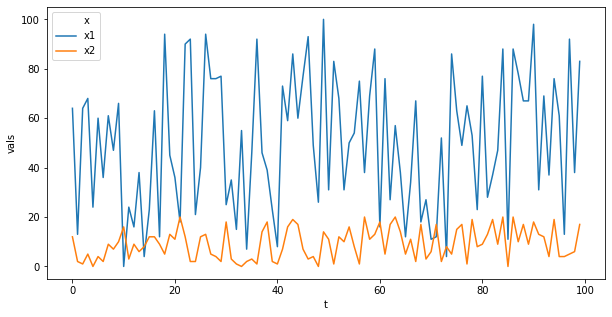

In [34]:
plt.figure(figsize=(10,5))
sns.lineplot(x=df["t"],y=df["vals"],hue='x', data=df)

In [1]:
import torch
import numpy as np

In [4]:
a = np.array([[1,1],[2,2]]).astype(np.float)

In [7]:
b = np.array([[3,3,3],[4,4,4]]).astype(np.float)

In [8]:
at = torch.from_numpy(a)
bt = torch.from_numpy(b)

In [11]:
torch.cat([at,bt],dim=1)

tensor([[1., 1., 3., 3., 3.],
        [2., 2., 4., 4., 4.]], dtype=torch.float64)

In [4]:
from torch_geometric.nn import GCNConv, SAGEConv, avg_pool